# Week 5 GANs Kaggle Project

## Project description:
The project aims to implement a CycleGAN (Cycle-Consistent Generative Adversarial Network) to transform photos into Monet-style paintings and vice versa. The goal is to train two generators and two discriminators in tandem:

    Generators: Transform images from the Photo domain to the Monet domain and vice versa.
    Discriminators: Differentiate between real and generated images in each domain.

The model achieves domain translation without paired data.The CycleGAN architecture is particularly useful for tasks where obtaining paired datasets is infeasible, such as style transfer, artistic rendering, and domain adaptation.

This specific project uses a Kaggle dataset of Monet paintings and real-world photos to:

    Generate Monet-style paintings from photos.
    Generate realistic photos from Monet paintings.

The output will include both a trained model and generated images showcasing the transformation.

Note: My GAN model from scratch was taking far too long to run. To be able to submit for this assignment I utilized the code provided in this [tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial). Tensorflow-addons was not able to install in my environment, the code has been updated to work around this through using different libraries. 

## Dataset Description

The dataset is provided as TFRecord files, containing images preprocessed to a uniform size of 256x256 pixels. It consists of two main groups:

    Monet Dataset:
        A collection of images of Monet-style paintings.

    Photo Dataset:
        A collection of real-world photos.

File Structure

    Monet TFRecords:
        Files: monetXX-YY.tfrec (e.g., monet12-60.tfrec)
        Each file contains a batch of Monet paintings.

    Photo TFRecords:
        Files: photoXX-YY.tfrec (e.g., photo12-352.tfrec)
        Each file contains a batch of photos.

### Libraries & Setup

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import os

#### Instance Normalization Layer

Defines a custom layer for instance normalization, which normalizes across the spatial dimensions (height and width) of feature maps, commonly used in GANs for stable training.

In [30]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True,
            name='gamma'
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name='beta'
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta


#### Load Dataset

In [31]:
MONET_FILENAMES = [os.path.join('/kaggle/input/gan-getting-started/monet_tfrec', fname) 
                   for fname in os.listdir('/kaggle/input/gan-getting-started/monet_tfrec')]

PHOTO_FILENAMES = [os.path.join('/kaggle/input/gan-getting-started/photo_tfrec', fname) 
                   for fname in os.listdir('/kaggle/input/gan-getting-started/photo_tfrec')]

print('Number of TFRecord files in Monet directory:', len(MONET_FILENAMES))
print('Number of TFRecord files in Photo directory:', len(PHOTO_FILENAMES))


Number of TFRecord files in Monet directory: 5
Number of TFRecord files in Photo directory: 20


MONET_FILENAMES and PHOTO_FILENAMES store the file paths of the respective datasets.
Prints the count of files to confirm successful dataset loading.

### EDA:

Check file names are being parsed correctly

In [32]:
print(MONET_FILENAMES)
print(PHOTO_FILENAMES)

['/kaggle/input/gan-getting-started/monet_tfrec/monet12-60.tfrec', '/kaggle/input/gan-getting-started/monet_tfrec/monet16-60.tfrec', '/kaggle/input/gan-getting-started/monet_tfrec/monet08-60.tfrec', '/kaggle/input/gan-getting-started/monet_tfrec/monet04-60.tfrec', '/kaggle/input/gan-getting-started/monet_tfrec/monet00-60.tfrec']
['/kaggle/input/gan-getting-started/photo_tfrec/photo12-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo11-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo05-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo08-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo18-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo06-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo17-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo10-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo09-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo15-352.tfrec'

### Preprocessing

All images are resized to 256 x 256 and scaled to a pixel range of [-1, 1] for compatibility with the CycleGAN architecture. This ensures uniformity across the dataset and simplifies input processing for the neural network.

#### Setup TPU & Strategy
Configures the training environment.

In [33]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE


IMAGE_SIZE = [256, 256]

Number of replicas: 1


In [34]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [35]:
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image


In [36]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

OUTPUT_CHANNELS = 3


In [37]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(InstanceNormalization())

    result.add(layers.LeakyReLU())

    return result

In [38]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(InstanceNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [39]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


In [40]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = InstanceNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [41]:
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()

    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()


In [42]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss


#### Build Model

In [43]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }   

In [44]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


#### Model Definition and Compilation
Creates and compiles the CycleGAN model with custom components.

    CycleGan: A custom model combining generators and discriminators.
    compile: Configures the model with optimizers and loss functions.

In [45]:

with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

#### Train Model
Trains the CycleGAN model.

    Saves model weights after each epoch using a ModelCheckpoint callback.
    Trains for 5 epochs on the zipped dataset.

In [47]:
from keras.callbacks import ModelCheckpoint

#define the checkpoint callback
checkpoint_path = "checkpoints/cycle_gan_weights.weights.h5"  
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,  #save weights at every epoch
    verbose=1
)

#train the model
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5,
    callbacks=[checkpoint_callback]
)

Epoch 1/5
    300/Unknown 1487s 5s/step - monet_disc_loss: 0.6834 - monet_gen_loss: 5.0891 - photo_disc_loss: 0.6900 - photo_gen_loss: 5.0811
Epoch 1: saving model to checkpoints/cycle_gan_weights.weights.h5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 1488s 5s/step - monet_disc_loss: 0.6836 - monet_gen_loss: 5.0844 - photo_disc_loss: 0.6901 - photo_gen_loss: 5.0775
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - monet_disc_loss: 0.6474 - monet_gen_loss: 3.6894 - photo_disc_loss: 0.6603 - photo_gen_loss: 3.6477
Epoch 2: saving model to checkpoints/cycle_gan_weights.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1468s 5s/step - monet_disc_loss: 0.6477 - monet_gen_loss: 3.6888 - photo_disc_loss: 0.6607 - photo_gen_loss: 3.6479
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - monet_disc_loss: 0.6438 - monet_gen_loss: 3.5309 - photo_disc_loss: 0.6518 - photo_gen_loss: 3.5213
Epoch 3: saving model to checkpoints/cycle_gan_weights.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1531s 5s/step - monet_disc_loss: 0.6441 - monet_gen_loss: 3.5303 - photo_disc_loss: 0.6521 - photo_gen_loss: 3.5213
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - monet_disc_loss: 0.6355 - monet_gen_loss: 3.4153 - photo_disc_loss: 0.6447 - 

## Results

Let's check a few visualizations to see how it did.

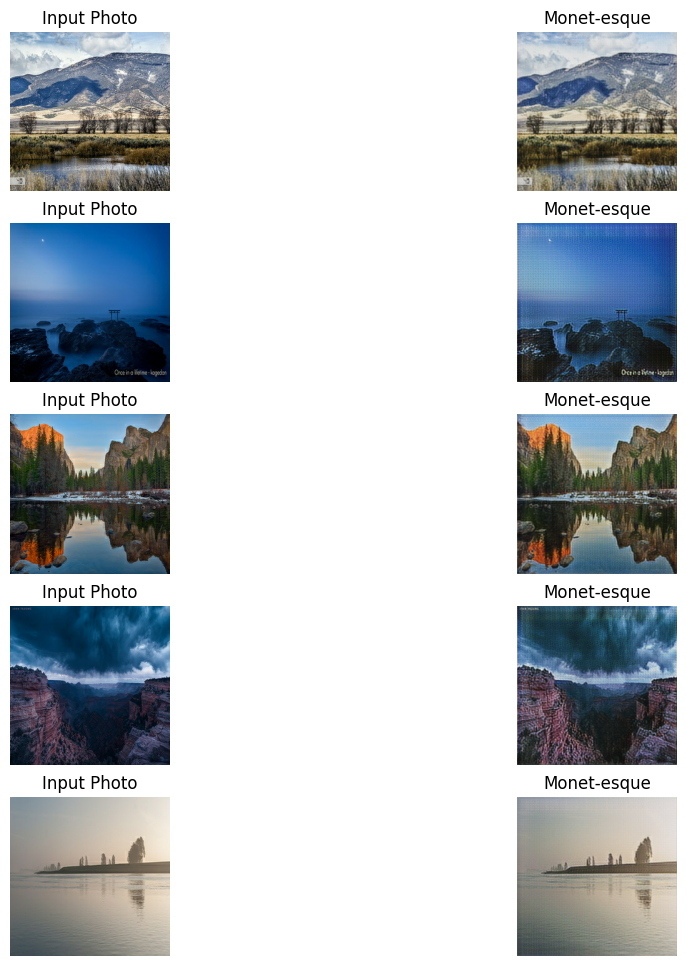

In [48]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()



#### Create submission

In [49]:
#create photos for submission
import PIL
! mkdir ../images


i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1



In [51]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## Conclusion & Discussion (with continued results analysis)

Discriminator Loss:

    Monet Discriminator Loss decreased from 0.6836 to 0.6330.
    Photo Discriminator Loss decreased from 0.6901 to 0.6396.

These losses indicate that the discriminators improved their ability to distinguish between real and generated images as training progressed.

Generator Loss:

    Monet Generator Loss decreased from 5.0844 to 3.3042.
    Photo Generator Loss decreased from 5.0775 to 3.3081.

These reductions suggest that the generators became more adept at fooling the discriminators over the epochs.

Epoch Duration:

    Training time per epoch averaged around 1500 seconds (25 minutes).


Based on the plot below, both Monet and the photo discrimator losses descrease steadily showign that the discrimintors are in fact improving at distinguishing between the two categories. Additionally, both of the generator losses decrease, indicating that the generators are learning how to fool discrimintors over time. 

For my model I ran 5 epochs. In the future, with more time, I would run the full 15 to analyze if we could improve the losses more over more epochs. 

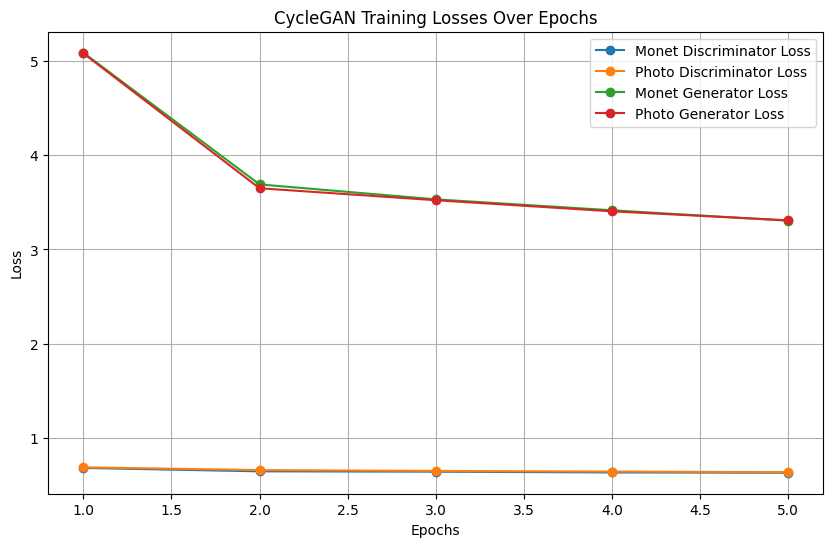

In [50]:
import matplotlib.pyplot as plt

#training data: Losses per epoch
epochs = [1, 2, 3, 4, 5]
monet_disc_loss = [0.6836, 0.6477, 0.6441, 0.6358, 0.6330]
monet_gen_loss = [5.0844, 3.6888, 3.5303, 3.4147, 3.3042]
photo_disc_loss = [0.6901, 0.6607, 0.6521, 0.6450, 0.6396]
photo_gen_loss = [5.0775, 3.6479, 3.5213, 3.4036, 3.3081]

#plotting the losses
plt.figure(figsize=(10, 6))

#discriminator losses
plt.plot(epochs, monet_disc_loss, label="Monet Discriminator Loss", marker="o")
plt.plot(epochs, photo_disc_loss, label="Photo Discriminator Loss", marker="o")

#generator losses
plt.plot(epochs, monet_gen_loss, label="Monet Generator Loss", marker="o")
plt.plot(epochs, photo_gen_loss, label="Photo Generator Loss", marker="o")

plt.title("CycleGAN Training Losses Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()
